# Steam Games Data Analysis
This notebook covers an analysis of Steam, the digital PC games platform. It uses two APIs; one is the official Steam API, the other is [Steam Spy](https://https://steamspy.com/api.php).

In [ ]:
import pandas as pd
import requests
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Steam API endpoint
url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"

# Send request
response = requests.get(url)
data = response.json()

# Extract the apps list
apps = data['applist']['apps']

# Convert to DataFrame
df = pd.DataFrame(apps)

# Show a few rows
print(df.head())
print(f"Total games: {len(df)}")

   appid                   name
0      5       Dedicated Server
1      7           Steam Client
2      8                 winui2
3     10         Counter-Strike
4     20  Team Fortress Classic
Total games: 273113


The two methods below, parse_steam_release_year and GetGameInfoDF, are used to extract relevant data about Steam games.

In [ ]:
# Takes in a release date string from Steam (i.e., in format like "Jan 1, 1999") and
# returns only the year as an int by stripping the string.
def parse_steam_release_year(release_date_str):
    try:
        return int(release_date_str.split(',')[1].strip())
    except (IndexError, ValueError, AttributeError):
        return None

# Makes a call to the Steam store API, passing in the game's appid and
# returns a dataframe with relevant data.
def GetGameInfoDF(appid, country='us'): # By default, United States
    url = f"https://store.steampowered.com/api/appdetails?appids={appid}&cc={country}"
    country = "us"
    response = requests.get(url)
    data = response.json()

    # Check if data for the appid exists
    if not data or str(appid) not in data or data[str(appid)] is None or 'data' not in data[str(appid)]:
      print(f"No data found for appid: {appid}")
      return None

    game_data = data[str(appid)]['data']

    # Extract price data
    price_info = game_data.get('price_overview', None)

    if price_info:
        price_usd = price_info['final'] / 100  # put price into a standard form
        currency = price_info.get('currency', 'USD')
    else:
        price_usd = 0.0
        currency = 'USD'

    # Extract other details
    name = game_data.get('name')
    release_date = game_data.get('release_date', {}).get('date')
    genres = [g['description'] for g in game_data.get('genres', [])]

    # Build the DataFrame
    df = pd.DataFrame([{
        'name': name,
        'appid': appid,
        'price_usd': price_usd,
        'currency': currency,
        'release_year': parse_steam_release_year(release_date),
        'genres': ', '.join(genres),
    }])

    return df

In [ ]:
# returns a Dataframe with the top 100 games by activity and owners,
# via Steam Spy
from tqdm import tqdm

def top100():
  steamspy_url = "https://steamspy.com/api.php?request=top100in2weeks"
  spy_data = requests.get(steamspy_url).json()

  # Convert to DataFrame with data relevant to top 100 ranking
  spy_df = pd.DataFrame(spy_data).T
  spy_df["appid"] = spy_df["appid"].astype(int)
  spy_df["owners"] = spy_df["owners"].astype(str)
  spy_df["ccu"] = spy_df["ccu"].astype(int) # ccu: Concurrent players


  # Get official game info from Steam and add into a list
  all_games = []
  for appid in tqdm(spy_df["appid"][:100]):
      game_info = GetGameInfoDF(appid, 'us')
      if game_info is not None:
          all_games.append(game_info)

  # Merge the datasets to gather all info in one place
  store_df = pd.concat(all_games, ignore_index=True)
  merged_df = pd.merge(spy_df, store_df, on="appid", how="inner")

  # fix userscore column; for some reason doesn't retrieve this properly
  merged_df["userscore"] = merged_df["positive"] / (merged_df["positive"] + merged_df["negative"]) * 100
  merged_df["userscore"] = merged_df["userscore"].astype(int)

  return merged_df

# Top 15 games by CCU (Concurrent player count)

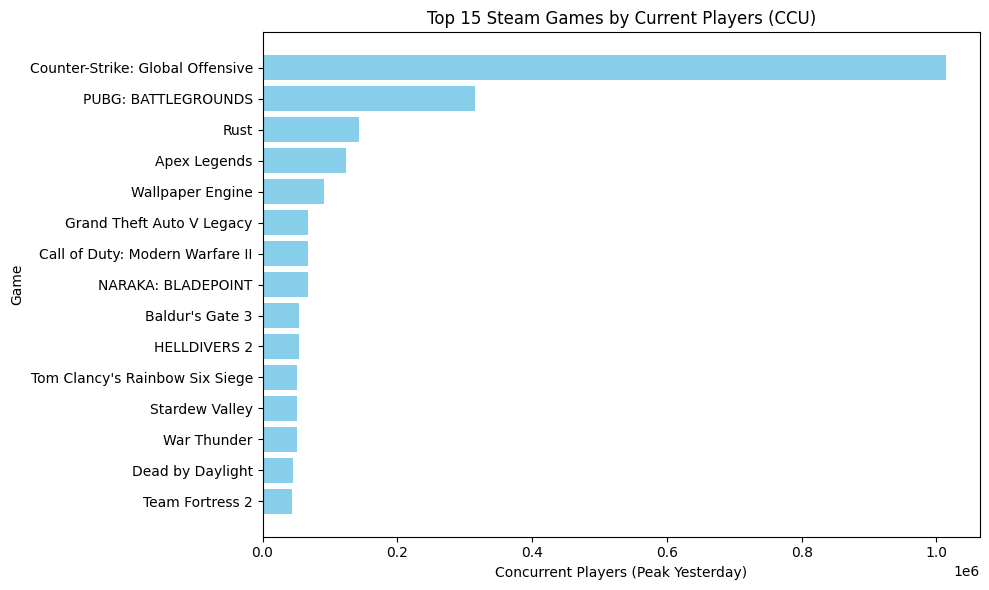

In [22]:
# Top 15 games by current players
steamspy_url = "https://steamspy.com/api.php?request=top100in2weeks"
spy_data = requests.get(steamspy_url).json()

# Convert to DataFrame
spy_df = pd.DataFrame(spy_data).T
top_games = spy_df.sort_values("ccu", ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_games["name"], top_games["ccu"], color='skyblue')
plt.gca().invert_yaxis()  # put the largest value at the top
plt.title("Top 15 Steam Games by Current Players (CCU)")
plt.xlabel("Concurrent Players (Peak Yesterday)")
plt.ylabel("Game")
plt.tight_layout()
plt.show()

In [ ]:
top100 = top100()
top100

100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


,appid,name_x,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,...,median_2weeks,price,initialprice,discount,ccu,name_y,price_usd,currency,release_year,genres
0,730,Counter-Strike: Global Offensive,Valve,Valve,,7642084,1173003,86,"100,000,000 .. 200,000,000",33947,...,312,0,0,0,1013936,Counter-Strike 2,0.00,USD,2012,"Action, Free To Play"
1,1172470,Apex Legends,Respawn,Electronic Arts,,668053,326926,67,"100,000,000 .. 200,000,000",9640,...,316,0,0,0,124262,Apex Legends™,0.00,USD,2020,"Action, Adventure, Free To Play"
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",,1520457,1037487,59,"100,000,000 .. 200,000,000",23504,...,315,0,0,0,314682,PUBG: BATTLEGROUNDS,0.00,USD,2017,"Action, Adventure, Massively Multiplayer, Free..."
3,1623730,Palworld,Pocketpair,Pocketpair,,358266,22443,94,"50,000,000 .. 100,000,000",3810,...,208,2999,2999,0,18028,Palworld,29.99,USD,2024,"Action, Adventure, Indie, RPG, Early Access"
4,440,Team Fortress 2,Valve,Valve,,1044264,117208,89,"50,000,000 .. 100,000,000",22515,...,132,0,0,0,43819,Team Fortress 2,0.00,USD,2007,"Action, Free To Play"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,221100,DayZ,Bohemia Interactive,Bohemia Interactive,,330349,99903,76,"10,000,000 .. 20,000,000",14291,...,467,4999,4999,0,37066,DayZ,49.99,USD,2018,"Action, Adventure, Massively Multiplayer"
96,526870,Satisfactory,Coffee Stain Studios,Coffee Stain Publishing,,225479,6585,97,"10,000,000 .. 20,000,000",5713,...,590,2799,3999,30,12596,Satisfactory,27.99,USD,2024,"Adventure, Indie, Simulation, Strategy"
97,1089350,NBA 2K20,Visual Concepts,2K,,30260,30413,49,"5,000,000 .. 10,000,000",6943,...,1,0,0,0,221,NBA 2K20,0.00,USD,2019,"Simulation, Sports"
98,632360,Risk of Rain 2,Hopoo Games,Gearbox Publishing,,293127,20450,93,"5,000,000 .. 10,000,000",3539,...,148,2499,2499,0,7902,Risk of Rain 2,24.99,USD,2020,"Action, Indie"


# What genres make up the top 100?

In [ ]:
# Group by genre to show how many games of each genre are in top100 (only look at the first genre of each game)
genre_counts = top100['genres'].str.split(', ', expand=True).stack().value_counts()
print(genre_counts)


Action                   78
Adventure                43
RPG                      32
Indie                    32
Free To Play             28
Simulation               25
Massively Multiplayer    22
Strategy                 16
Casual                   11
Early Access              9
Sports                    7
Animation & Modeling      1
Photo Editing             1
Design & Illustration     1
Utilities                 1
Racing                    1
Name: count, dtype: int64


# Average Prices of Games by Genre

In [ ]:
# The following helper method will help us get average price of genres, given
# a dataframe. This is useful when we analyze the performances of each genre.
def compute_avg_price_genre(genre, df):
  genre_df = df[df["genres"].str.contains(genre, na=False)]
  return genre_df["price_usd"].mean()

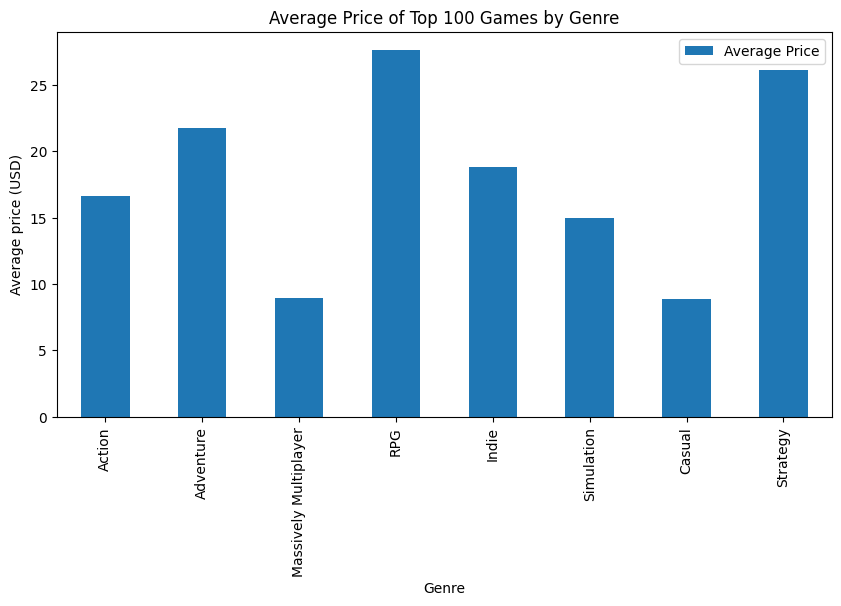

In [ ]:
genres_examined = ['Action', 'Adventure', 'Massively Multiplayer', 'RPG', 'Indie', 'Simulation', 'Casual', 'Strategy'] #set to whatever genres we want to look at
# get average price_usd of each genre via compute_avg_price_genre,  then plot them in bar graph?
genres_with_avg = pd.DataFrame(columns=["Genre", "Average Price"])

data = []

for genre in genres_examined:
  avg = compute_avg_price_genre(genre, top100)
  data.append({"Genre": genre, "Average Price": avg})

#Create dataframe
genres_with_avg = pd.DataFrame(data)
#plot
genres_with_avg.plot(kind="bar", x="Genre", y="Average Price", figsize=(10,5))
plt.title("Average Price of Top 100 Games by Genre")
plt.ylabel("Average price (USD)")
plt.xlabel("Genre")
plt.show()

*** A lot of the top 100 are free-to-play games, which cause the prices to drop in average. We can duplicate the dataframe and drop the rows where the game is free, to see how they affect the data.

(100, 22)
(62, 22)


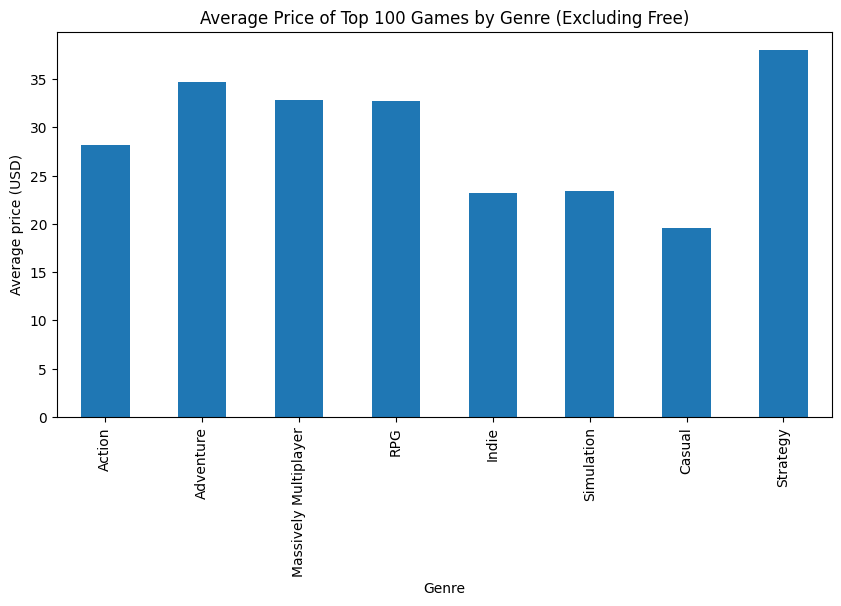

In [24]:
# Redo above, but first drop from 100 where price_usd = 0.
top100_no_free = top100[top100["price_usd"] > 0]

print(top100.shape)
print(top100_no_free.shape) # To see how many games are ignored here

data = []
# Use compute_avg_price_genre and put into dataframe for plotting

for genre in genres_examined:
  avg = compute_avg_price_genre(genre, top100_no_free)
  data.append({"Genre": genre, "Average Price": avg})

#Create dataframe
genres_with_avg = pd.DataFrame(data)

#plot
genres_with_avg.plot(kind="bar", x="Genre", y="Average Price", figsize=(10,5),legend=False)
plt.title("Average Price of Top 100 Games by Genre (Excluding Free)")
plt.ylabel("Average price (USD)")
plt.xlabel("Genre")
plt.show()

Now, above we are able to see the "true" average price for each genre. While about 40 games get dropped, we can still observe which games appear to have more free to play games based on how much their average changes.

# Factors corresponding to rating


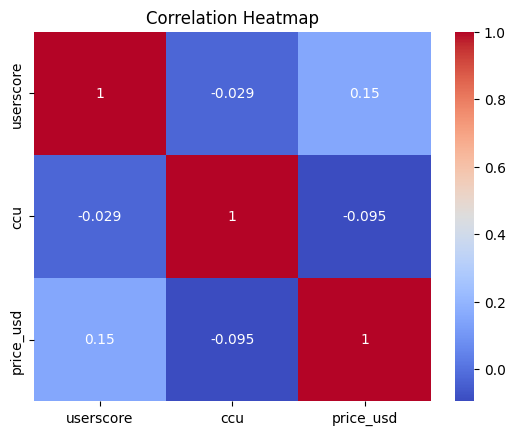

In [ ]:
subset = top100.drop('appid', axis=1)
sns.heatmap(subset.corr(numeric_only = True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Unfortunately, there are not many numeric factors available to us, but it appears that no patterns really exist between userscore, concurrent players, and the price.

# Mean owners vs mean price by genre

In [ ]:
# This method parses and calculates the average owner count for a game,
# since due to individual user privacy settings, a range rather than an exact number is given.
def parse_owners(x):
    if isinstance(x, str) and " .. " in x:
        low, high = x.split(" .. ")
        return (int(low.replace(',', '')) + int(high.replace(',', ''))) / 2
    return np.nan

# This method calculates average owners per dollar of a game.
def price_vs_owners_df(data):
  mean_owners = data.copy()

  mean_owners["owners_mid"] = mean_owners["owners"].apply(parse_owners)

  # Extract primary genre (first genre if multiple)
  mean_owners["primary_genre"] = mean_owners["genres"].apply(lambda x: x.split(",")[0].strip() if isinstance(x, str) else np.nan)

  # Calculate hours played
  mean_owners["hours_played"] = mean_owners["average_forever"] / 60 # convert minutes to hours

  # Group by primary genre
  genre_stats = mean_owners.groupby("primary_genre")[["price_usd", "owners_mid", "hours_played"]].mean().reset_index()

  # Calculate owners per dollar
  genre_stats = genre_stats[genre_stats["price_usd"] > 0]
  genre_stats["owners_per_dollar"] = genre_stats["owners_mid"] / genre_stats["price_usd"]

  return genre_stats

In [ ]:
def plot_price_vs_owners(genre_stats):
  x = genre_stats["price_usd"].fillna(0).values
  y = genre_stats["owners_mid"].fillna(0).values
  playtime = pd.to_numeric(genre_stats["hours_played"], errors="coerce").fillna(0.1).values

  min_size, max_size = 50, 500
  s = min_size + (playtime - playtime.min()) / (playtime.max() - playtime.min()) * (max_size - min_size)

  plt.figure(figsize=(10,6))
  sc = plt.scatter(
      x,
      y,
      s=s,
      c=playtime,
      cmap="plasma",
      alpha=0.8,
      edgecolors="black"
  )

  for i, row in genre_stats.iterrows():
      if not np.isnan(row["price_usd"]) and not np.isnan(row["owners_mid"]):
          plt.text(row["price_usd"], row["owners_mid"], row["primary_genre"], fontsize=8, ha='left', va='bottom')

  plt.yscale("log")
  plt.xlabel("Mean Price ($)")
  plt.ylabel("Mean Owners")
  cbar = plt.colorbar(sc, label="Average Playtime (hours)")
  plt.title("Genre Comparison: Price vs Owners")
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

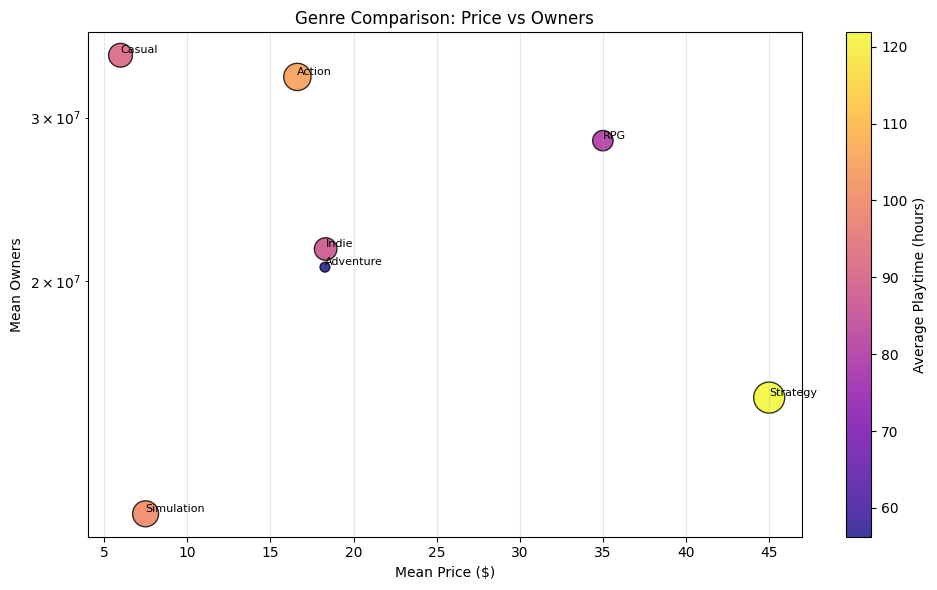

In [ ]:
ppvo = price_vs_owners_df(top100)
plot_price_vs_owners(ppvo)

**Price Vs Owner Comparison when excluding free games**

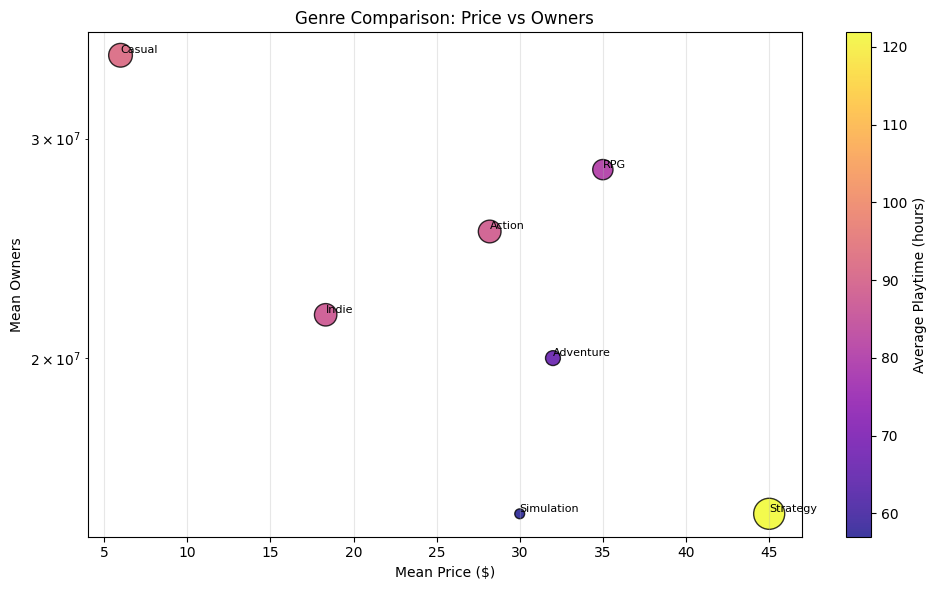

In [ ]:
ppvo_free = price_vs_owners_df(top100_no_free)
plot_price_vs_owners(ppvo_free)

We can see a slight change in how for each genre, mean price corresponds with mean owners, and we also get some insight into how playtime changes for some genres based on the inclusion of free/paid games.

# Price vs Rating

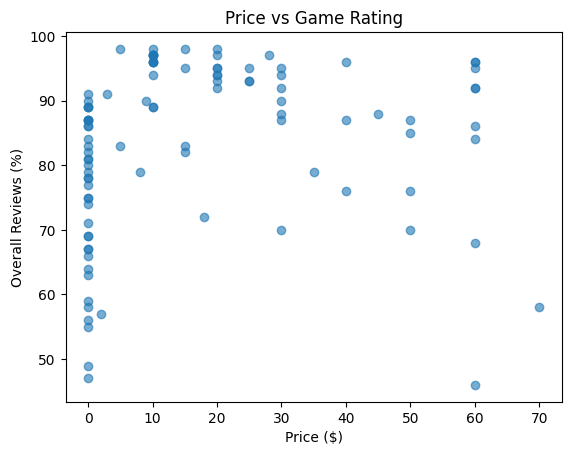

In [ ]:
price_vs_rating = top100.copy()

price_vs_rating['hours_played'] = price_vs_rating['average_forever'] / 60
price_vs_rating['primary_genre'] = price_vs_rating['genres'].apply(lambda x: x.split(",")[0].strip() if isinstance(x, str) else np.nan)

# Drop rows with missing values in the relevant columns
price_vs_rating = price_vs_rating.dropna(subset=['price_usd', 'userscore'])

X = price_vs_rating[['price_usd']]
y = price_vs_rating['userscore']

import matplotlib.pyplot as plt

plt.scatter(price_vs_rating['price_usd'], price_vs_rating['userscore'], alpha=0.6)
plt.xlabel("Price ($)")
plt.ylabel("Overall Reviews (%)")
plt.title("Price vs Game Rating")
plt.show()


# Does release year affect average rating? (top 100)

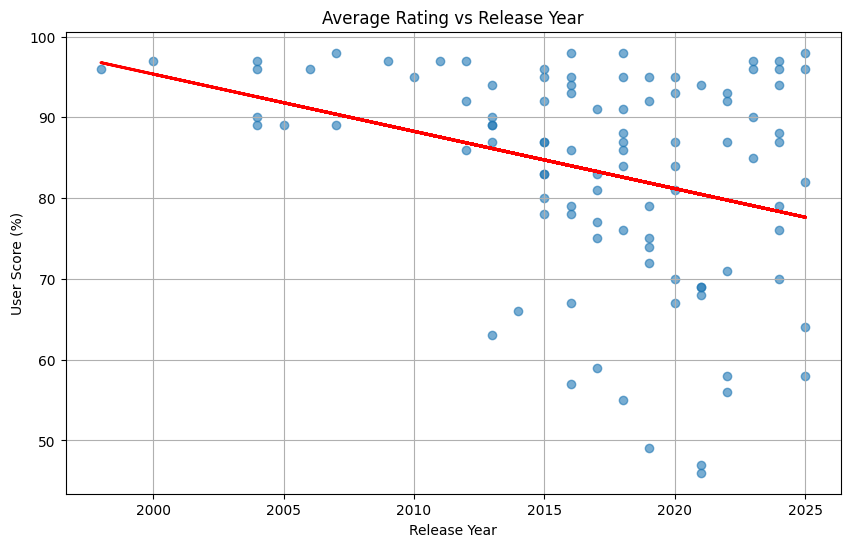

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Drop rows with missing year or rating
year_vs_rating = top100.copy().dropna(subset=['release_year', 'userscore'])

x = year_vs_rating['release_year'].values
y = year_vs_rating['userscore'].values

def mse(betas):
    # betas[0] = intercept, betas[1] = slope
    return np.mean((y - (betas[0] + betas[1] * x)) ** 2)

result = minimize(mse, [0, 0])
betas = result.x

def lobf(x):
    return betas[0] + betas[1] * x

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, lobf(x), color='red', linewidth=2)

plt.xlabel("Release Year")
plt.ylabel("User Score (%)")
plt.title("Average Rating vs Release Year")
plt.grid(True)
plt.show()